# Introduction

This notebook details the structure of the library which will become common APIs for all methods as well as wrapper to help run the benchmark.

In [963]:
# path imports
import os
import sys

# Get the repo base path assuming you're in a notebook at root or in a subfolder
repo_root = os.path.abspath(os.path.join(os.getcwd(), ''))  # or add '..' to go up

# Add the benchmarks subdir to sys.path
bench_path = os.path.join(repo_root, 'benchmarks')
ddgclib_path = os.path.join(repo_root, 'ddgclib')
if [bench_path, ddgclib_path] not in sys.path:
    sys.path.append(bench_path)

## Base class for testing a collection of methods
First we import the `GeometryBenchmarkBase` class which is the base class for running a method on all benchmarks classes, and the `run_all_benchmarks` function which is used to run all benchmarks in the library.

For comparing different methods, every method should initiated its own class.

In [964]:
from benchmarks._benchmark_classes import run_all_benchmarks, GeometryBenchmarkBase

run_all_benchmarks

<function benchmarks._benchmark_classes.run_all_benchmarks(benchmark_classes, method=None, complex_dtype='vf')>

## Method Wrappers

In the cell below we speficy the example template methods, all available methods are saved in the `ddgclib._method_wrappers` module. The methods are used to compute curvature, area, and volume of the simplicial complexes.

E.g. currently there are template methods like:

```python
_curvature_i_methods = {
    "laplace-beltrami": compute_laplace_beltrami,
}

_area_i_methods = {
    "default": compute_area_vertex_default,
}

_area_ijk_methods = {
    "default": compute_area_triangle_default,
}

_area_methods = {
    "default": compute_area_triangle_default,
}

_volume_methods = {
    "default": compute_volume_default,
}
```

so we can specify a methods dict like:

In [965]:
method = {
    "curvature_i_method": "laplace-beltrami",
    "area_i_method": "default",
    "area_ijk_method": "default",
    "area_method": "default",
    "volume_method": "default",
}


The second important parameter is the `complex_dtype` which specifies the data type of the simplicial complex. It can be a hypect Complex object ('vv') or a tuple of numpy arrays (vertices, simplices) specified using 'vf' such as we have with `scipy`'s `Delaunay` function. The latter is intended for methods which cannot use dual vertices for whatever reason.

The final class can then be called like:

In [966]:
GeometryBenchmarkBase(method=method, complex_dtype='vv')

In [967]:
from ddgclib._method_wrappers import Curvature_i, Area_i, Area_ijk, Volume
curvature_i = Curvature_i()
area_i = Area_i()
area_ijk = Area_ijk()
volume = Volume()

## Geometry Benchmark Framework Overview

This section demonstrates the structure of a case geometry benchmark system designed to evaluate curvature, surface area, and volume computations on 3D simplicial complexes. Each benchmark case corresponds to a known geometry with analytical expressions.

---

## Required Functions for Any Benchmark Case

Each benchmark case (e.g., `TorusBenchmark`) should inherit from `GeometryBenchmarkBase` and implement the following:

### 1. `generate_mesh()`
Generates the mesh (vertices and simplices). For `'vf'` style, this is a 2-array representation:

```python
self.points      # shape (N, 3)
self.simplices   # shape (M, 3)
```

## Additional Analytical Tools (Implemented Per Benchmark)

These functions provide analytical evaluations to support local accuracy assessments. Each benchmark class should implement them when possible.

### `f(u, v)`

The parametric surface map $f:\mathbb{R}^2 \rightarrow \mathbb{R}^3$ from 2D domain to 3D:

$$
f(u, v) = (x(u, v), y(u, v), z(u, v))
$$

This maps a parametric domain (e.g., a UV grid) to the embedded 3D surface used for benchmarking.

---

### `H(u, v)`

Pointwise analytical **mean curvature**:

$$
H(u, v) = \text{analytical expression for mean curvature at } (u, v)
$$

This is used for comparing local curvature errors per vertex or triangle.

---

### `dA(uv_i, uv_j, uv_k)`

Computes the **integrated surface area** over a parametric triangle:

$$
\int_{\Omega} dA
$$

where \( \Omega \) is the triangle defined by parametric vertices \( uv_i, uv_j, uv_k \).

---

### `HNdA(uv_i, uv_j, uv_k)`

Computes the *integrated mean normal curvature* over a triangle area domain:

$$
\int_{\Omega} H(u, v) \bf{N} dA
$$

Useful for comparing discrete integrated curvature per simplex against analytical values.


## Visualization

Optionally all the test cases should have a simple visualization of the geometry, this will be especially later useful when we convert these to polyscope to better visualize local errors on the geometry.

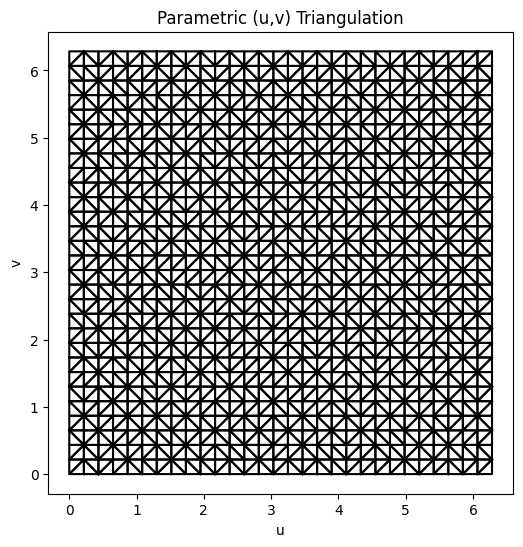

In [968]:
from benchmarks._benchmark_cases import TorusBenchmark

# Instantiate the benchmark
torus = TorusBenchmark(
    R_major=2.0,
    r_minor=1.0,
    n_u=30,
    n_v=30,
    method={  # method dict with per-quantity control
        "curvature_i_method": "laplace-beltrami",
        "area_i_method": "default",
        "area_ijk_method": "default",
        "area_method": "default",
        "volume_method": "default",
    },
    complex_dtype="vf"
)

# Torus generate mesh
torus.generate_mesh()
# Plot parametric (u,v) triangulation
torus.plot_uv_triangulation()


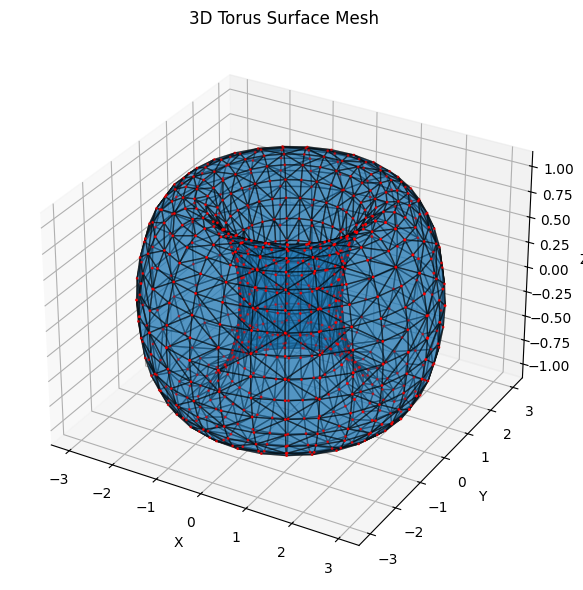

In [969]:

# Plot 3D surface mesh
torus.plot_surface_mesh()

# Curved Volume on Triangulated Surfaces — Notebook Overview

> This notebook computes **curved volumes** on a triangulated surface by  
> (1) fitting/normalizing **quadric surfaces** per vertex,  
> (2) transforming geometry to **canonical frames**,  
> (3) evaluating **curved patch volumes** (solid-angle / swept-segment), and  
> (4) **thickness-weighted splitting** back to vertices.  
> Results are validated against analytic volumes (e.g., ellipsoids).

---

## 1. What this notebook does

1. **Fit local quadrics** at mesh vertices  
   Each vertex gets coefficients for the quadratic surface:
   $$
   f(x,y,z)=A x^2+B y^2+C z^2+Dxy+Exz+Fyz+Gx+Hy+Iz+J=0.
   $$
   Small coefficients are regularized; “smart normalization” prefers $J=-1$ when stable, otherwise $H=+1$ for paraboloid-like cases.

2. **Canonicalize & transform**  
   Translate to the local center, rotate to principal axes, and **post-scale** to unitized space:
   $$
   \mathbf{p}'=\mathbf{R}^{\top}(\mathbf{p}-\mathbf{c}), \qquad
   \mathbf{p}''=\mathbf{p}' \oslash \text{scale\_factors1}.
   $$
   Detect surface type (ellipsoid / cylinder / paraboloid / hyperboloid) and snap parameters for robust downstream formulas.

3. **Compute curved patch volumes** for each triangle  
   Use **solid-angle wedge volumes** on the unit sphere and/or **swept-segment** / axisymmetric formulas.  
   Combine wedge/cap corrections to obtain the **curved volume correction** relative to the flat tetrahedral reference.

4. **Thickness-weighted split to vertices**  
   Split each triangle’s curved volume into $(A,B,C)$ contributions with a **thickness-weighted rule**, improving conservation and stability on irregular meshes.

5. **Aggregate & validate**  
   Sum per-triangle (and per-vertex) volumes.  
   Compare to ground truth (e.g., ellipsoid volume) and report relative error.

---

## 2. Coefficients computation
##### Files: `_1_coeffs_computing.py`

### 2.1 Quadric model

**Algebraic (1× convention)**  
$$
f(x,y,z)=A x^2 + B y^2 + C z^2 + D\,xy + E\,xz + F\,yz + G\,x + H\,y + I\,z + J = 0.
$$

**Homogeneous $4\times4$ form (reference)**  
$$
Q=
\begin{bmatrix}
A & D/2 & E/2 & G/2\\
D/2 & B & F/2 & H/2\\
E/2 & F/2 & C & I/2\\
G/2 & H/2 & I/2 & J
\end{bmatrix},\quad
\tilde p=\begin{bmatrix}x\\y\\z\\1\end{bmatrix},\quad
f=\tilde p^{\top} Q\,\tilde p.
$$

### 2.2 Patch selection & planarity guard

- **Smooth components (normal similarity):**  
  $$
  |\langle \mathbf{n}_i,\mathbf{n}_j\rangle|\ \ge\ \cos(\theta_{\max}).
  $$
  Patches grow $1$–$4$ rings inside the same component; if still too small, expand on a **smooth-only** vertex graph (won’t cross sharp edges).

- **Planarity SVD test:** with centered points $\mathbf{q}_i=\mathbf{p}_i-\bar{\mathbf{p}}$ and $Q=U\Sigma V^\top$, plane normal $\mathbf{n}=V_{[:,3]}$.  
  Reject as planar if
  $$
  \max_i \big|\,\mathbf{q}_i\cdot\mathbf{n}\,\big|\ \le\
  \max\!\bigl(\text{plane\_abs\_tol},\ \text{plane\_rel\_tol}\cdot \text{scale}\bigr).
  $$

### 2.3 Homogeneous least-squares fit (SVD)

For points $P_i=(x_i,y_i,z_i)$, build
$$
X=\begin{bmatrix}
x_i^2 & y_i^2 & z_i^2 & x_i y_i & x_i z_i & y_i z_i & x_i & y_i & z_i & 1
\end{bmatrix}_{i=1}^N.
$$
Solve
$$
\min_{\|c\|=1}\ \|Xc\|_2
\quad\Longrightarrow\quad
c=\text{right-singular vector of }X\text{for }\sigma_{\min}.
$$

### 2.4 Smart normalization & snapping (fit-time)

Define
$$
\text{thr}=\max\!\bigl(\text{tol\_abs},\ \text{tol\_rel}\cdot \max|A..I|,\ 10^{-3}\bigr).
$$
- If $|J|>\text{thr}$, rescale to $J=-1$; else if $|H|>\text{thr}$, rescale to $H=+1$; else keep as-is.  
- **Paraboloid-first:** if $A x^2 + B y^2 + I z + J \approx 0$ with $A\approx B$ and other terms $\approx 0$, scale to $A=+1$ (snap $B\!\to\!1$ if extremely close).  
- **Snap tiny terms:** for $t\in\{A,\dots,I\}$,
$$
|t|\le \max(\text{snap\_abs},\ \text{snap\_rel}\cdot \max(|A|,|B|,|C|,1))\ \Rightarrow\ t\gets 0.
$$
- **Hyperbola canonization (conditional):** when $x^2-y^2+J\approx 0$, set $A=+1,\,B=-1$ (keep $J$).

### 2.5 Outputs

Per triangle: coefficients for $A/B/C$ vertices and the union $(\text{ABC})$, patch sizes, component IDs, and coordinates.

---

## 3. Quadric transform
##### Files: `_2_quadric_transformer.py`

### 3.1 Quadratic block, rotation to major axes

Use the quadratic block and linear vector
$$
\mathbf{Q}=
\begin{bmatrix}
A & D/2 & E/2\\
D/2 & B & F/2\\
E/2 & F/2 & C
\end{bmatrix},\qquad
\mathbf{b}=\begin{bmatrix}G\\H\\I\end{bmatrix}.
$$

Diagonalize
$$
\mathbf{Q}=\mathbf{V}\,\Lambda\,\mathbf{V}^\top,\qquad
\Lambda=\operatorname{diag}(\lambda_1,\lambda_2,\lambda_3),
$$
choose $\mathbf{R}$ from eigenvectors (handle nullspace/axis-swap so the $z$ axis aligns with the weakest mode). Transform
$$
\mathbf{Q}'=\mathbf{R}^\top\mathbf{Q}\mathbf{R},\qquad \mathbf{b}'=\mathbf{R}^\top\mathbf{b},
$$
then recover
$$
\begin{aligned}
&A'=Q'_{00},\ B'=Q'_{11},\ C'=Q'_{22},\\
&D'=2Q'_{01},\ E'=2Q'_{02},\ F'=2Q'_{12},\\
&G'=b'_0,\ H'=b'_1,\ I'=b'_2,\ J'=J.
\end{aligned}
$$
Skip rotation if $C\approx E\approx F\approx I\approx D\approx 0$ (already $z$-invariant and $xy$-diagonal).

### 3.2 Post-scaling to canonical units

Set
$$
s_x=\frac{1}{\sqrt{|A|}}\ (\text{if }|A|>10^{-10}\ \text{else }1),\quad
s_y=\frac{1}{\sqrt{|B|}},\quad
s_z=\frac{1}{\sqrt{|C|}},
$$
with parabolic axis exceptions (e.g., along $x$, use $s_x=1$). Scale coefficients:
$
A^\star=A s_x^2,\ B^\star=B s_y^2,\ C^\star=C s_z^2,\ 
D^\star=D s_x s_y,\ E^\star=E s_x s_z,\ F^\star=F s_y s_z,\
G^\star=G s_x,\ H^\star=H s_y,\ I^\star=I s_z,\ J^\star=J.
$
Volume Jacobian:
$$
J_{\text{scale}}=s_x s_y s_z.
$$
If $|J^\star|>10^{-4}$ and $J^\star\ne-1$, rescale so $J^\star=-1$.

### 3.3 Affine pullback & vertex transform

With
$$
T(\mathbf{p}'')=\mathbf{R}\bigl((s_x,s_y,s_z)\odot \mathbf{p}''\bigr)+\mathbf{c},
$$
the pullback is
$$
Q_{\text{world}}=T^{-T}Q_{\text{canon}}T^{-1}.
$$
Triangle vertices to canonical:
$$
\boxed{\ \mathbf{p}_{\text{canon}}=\frac{\mathbf{R}^\top(\mathbf{p}-\mathbf{c})}{(s_x,s_y,s_z)}\ }.
$$

### 3.4 Surface classification (sign/zero pattern)

By signs of $(A,B,C)$ and whether $(G,H,I)$ vanish, decide among ellipsoid/cylinder/paraboloid/hyperboloid; use eigenvalue multiplicities for sphere/cylinder detection.

---

## 4. Translation-surface curved volume computation
##### Files: `_3_1_translation_curved_volume_computing.py`, `_3_2_shared_translation_conic_utils.py`

### 4.1 Slice to a 2D conic on $z=z_C$

Use the 11-term convention $F(x,y,z)=Ax^2+By^2+Cz^2+Dxy+Exz+Fyz+Gx+Hy+Jz+K$.  
At level $z=z_C$, the in-plane conic
$$
a x^2 + b xy + c_2 y^2 + d x + e y + f = 0
$$
has
$$
a{=}A,\quad b{=}D,\quad c_2{=}B,\quad d{=}G+E\,z_C,\quad e{=}H+F\,z_C,\quad f{=}C z_C^2 + J z_C + K.
$$

### 4.2 Cap areas via Green’s theorem

Let $Q_{\text{area}}(x,y)=x$. For an oriented arc $\mathcal{A}:P_0\!\to\!P_1$ on the conic and the closing chord $P_1\!\to\!P_0$,
$$
A_{\text{cap}}=\int_{\mathcal{A}} x\,dy + \tfrac12 (x_{0}+x_{1})(y_{0}-y_{1}).
$$

### 4.3 Flux decomposition and assembly

Define the vector-field primitive for curved sides
$$
Q_f(x,y)=\tfrac13 x^3 - x y^2.
$$
Planar $z$-flux across triangle $PQR$ is
$$
\iint_T z\,n_z\,dS=\Bigl(\tfrac12\bigl((Q{-}P)\!\times\!(R{-}P)\bigr)_z\Bigr)\cdot\frac{z_P+z_Q+z_R}{3}.
$$
Assemble the volume bounded by bottom arc $A\!\to\!B$, verticals $B\!\to\!B'$, $A'\!\to\!A$, and top arc $B'\!\to\!A'$:
$$
\boxed{\,V = I_{\text{flat}} - I_{\text{curved}} + z_{\text{high}}\,A_{\text{top}}^{\text{signed}} + z_{\text{low}}\,A_{\text{bot}}^{\text{signed}}\,},
$$
with $I_{\text{curved}}$ the sum of $Q_f\,dy$ along the four boundary pieces.

### 4.4 Robust line integrals & fast paths

Prefer $y$-parameterization
$$
\int_{y_0}^{y_1} Q\bigl(x(y),y\bigr)\,dy,
$$
or use $dy=-(g_x/g_y)\,dx$ with $g_x=2ax+by+d$, $g_y=bx+2c_2y+e$.  
Special cases: vertical cylinders, circles, parabolas $y=x^2$, ellipses, and hyperbolas admit closed-form area/length helpers.

### 4.5 Patch assembly for translation walls

Subdivide by $z$-ordering (top/mid/bot), combine base tets, two edge volumes, and length-weighted blending
$$
r=\frac{L_{\text{mid}}}{L_{\text{top}}+L_{\text{mid}}}
$$
to stabilize when one arc lies between the others.

---

## 5. Rotation-surface curved volume computation (axisymmetric)
##### Files: `_3_4_shared_axisymmetric_utils.py`, `_3_3_swept_segment_volume_AB.py`

### 5.1 Detect axis of revolution & principal frame

From $f(x)=x^\top A_3 x + 2\,b^\top x + J$ with
$$
A_3=\begin{bmatrix}
A & D/2 & E/2\\
D/2 & B & F/2\\
E/2 & F/2 & C
\end{bmatrix},\qquad
b=\tfrac12\begin{bmatrix}G\\H\\I\end{bmatrix},
$$
find the **center** $x_0$ by $A_3 x_0 + b = 0$, and eigendecompose $A_3=V\Lambda V^\top$.  
Axisymmetry $\Rightarrow$ **two equal** eigenvalues (radial) and one distinct (axial).  
Let $U=[u\ v\ k]$ be an orthonormal frame with $k$ along the axis; rotate $b$ into this frame: $(b_u,b_v,b_k)=U^\top b$.

### 5.2 Meridian equation $r^2(z)$ in the axis frame

Remove radial linear terms and complete the square in $z$:
$$
J_c = J - \frac{b_u^2+b_v^2}{\lambda_{\text{rad}}},\qquad
z_{\text{shift}}=\frac{b_k}{\mu_{\text{ax}}},\qquad
J' = J_c - \frac{b_k^2}{\mu_{\text{ax}}},
$$
then
$$
\boxed{\,r^2(z) = -\frac{\mu_{\text{ax}}\,(z+z_{\text{shift}})^2 + J'}{\lambda_{\text{rad}}}\,}\quad(\mu_{\text{ax}}\ne 0).
$$
If $\mu_{\text{ax}}=0$ (paraboloid-like),
$$
\boxed{\,r^2(z)= -\frac{2\,b_k\,z + J_c}{\lambda_{\text{rad}}}\,}.
$$

### 5.3 Swept-segment wedge by Pappus

Build the polygon in the meridian plane $(r,z)$ as **arc** $r(z)$ from $z_A\to z_B$ plus the **closing chord** $(z_B,r_B)\to(z_A,r_A)$.  
Shoelace area and centroid radius:
$$
A_{\!rz}=\frac12\sum_i (r_i z_{i+1}-r_{i+1}z_i),\qquad
C_r=\frac{1}{6A_{\text{signed}}}\sum_i (r_i+r_{i+1})(r_i z_{i+1}-r_{i+1}z_i).
$$
Pappus’ centroid theorem then gives the **revolved wedge volume**
$$
\boxed{\,V_{\text{wedge}}=2\pi\,|C_r|\,A_{\!rz}\,}.
$$

### 5.4 Frustum & sector corrections on triangles

For endpoints with radii $r_A,r_B$ and height $h=|z_B-z_A|$,
$$
V_{\text{frustum}}=\frac{\pi h}{3}\,(r_A^2 + r_A r_B + r_B^2).
$$
For an angular span $\Delta\theta$ at radius $r$,
$$
A_{\text{sector-tri}}=\tfrac12\,r^2\sin\Delta\theta,\qquad
\text{split}=\frac{2\pi}{\Delta\theta}.
$$
Per-triangle **rotation patches** combine frustums, swept-segment wedges, and tetrahedral corrections
$$
V_{\text{tet}}=\frac{1}{6}\,\bigl|\det([B-A,\ C-A,\ D-A])\bigr|,
$$
with case logic depending on whether a triangle edge is at constant $z$ and whether the third vertex lies **between** or **outside** the edge in angle.

### 5.5 Edge tools (used by the patch assembly)

- **Extend to $z$-plane:** intersect the straight edge with $z=z_C$ and set its polar angle $\theta$; place the point on the axisymmetric surface with target radius $r(z_C)$.  
- **Cylinder angle normalization:** $\theta=\operatorname{atan2}(y,x)$ wrapped to $[0,2\pi)$.  
- **Curved-tet sampler (fallback):** approximate an arc at fixed radius and integrate a strip of small tets; used only in difficult corner cases.

### 5.6 Orientation & curvature labels

Principal curvatures at a point $Q$ on $f=0$ use
$$
\nabla f=2\,(A_3 Q + b),\qquad H=2\,A_3,
$$
projected to any orthonormal tangent basis to build a $2\times2$ shape operator whose eigenvalues are $(k_1,k_2)$.  
A simple rule labels triangles **outward/inward/between** from the signs of $(k_2)$ at the three vertices and selects the corresponding rotation patch formula.

---

## 6. Ellipsoid curved volume computation (sphere → ellipsoid lift)
##### Files: `_3_5_volume_ellipsoid.py`

This chapter summarizes the ellipsoid logic used to compute **curved-volume corrections** from the unit-sphere formulas, then scale them to the ellipsoid using the Jacobian of the canonical transform.

### 6.1 Map triangle to unit sphere

Given transformed vertices $A,B,C$ and per-triangle scales $(s_x,s_y,s_z)$:

1) Choose the **unit-sphere mapping scale**  
If the fitted coefficients match a unit sphere and $\|A\|\!\approx\!\|B\|\!\approx\!\|C\|\!\approx\!1$, use $s_{\text{to\_unit}}=(1,1,1)$; otherwise use $(s_x,s_y,s_z)$.

2) Normalize to the sphere and unit-length the points:
$$
a=\frac{A/s_{\text{to\_unit}}}{\|A/s_{\text{to\_unit}}\|},\quad
b=\frac{B/s_{\text{to\_unit}}}{\|B/s_{\text{to\_unit}}\|},\quad
c=\frac{C/s_{\text{to\_unit}}}{\|C/s_{\text{to\_unit}}\|}.
$$
The triangle orientation is $\operatorname{sign}\big(a\cdot (b\times c)\big)$.

### 6.2 Sphere-space wedge and flat reference

$$
\Omega \;=\; 2\,\operatorname{atan2}\!\Big(\big|a\cdot(b\times c)\big|\;,\; 1+a\!\cdot\!b+b\!\cdot\!c+c\!\cdot\!a\Big),\qquad
V_{\text{wedge}}^{\mathbb{S}^2}=\frac{\Omega}{3},\quad
V_{\text{flat}}^{\mathbb{S}^2}=\frac{\big|a\cdot(b\times c)\big|}{6}.
$$
Sphere-space correction:
$$
V_{\text{corr}}^{\mathbb{S}^2}=V_{\text{wedge}}^{\mathbb{S}^2}-V_{\text{flat}}^{\mathbb{S}^2}.
$$

### 6.3 Lift to ellipsoid via Jacobian

Ellipsoid scaling $(x,y,z)\mapsto (s_x x,\ s_y y,\ s_z z)$ has volume Jacobian
$$
J_{\text{ellip}}=s_x s_y s_z.
$$
Hence
$$
\boxed{\,V_{\text{corr}}^{\text{ellip}}=J_{\text{ellip}}\;V_{\text{corr}}^{\mathbb{S}^2}\,}.
$$

### 6.4 Per-vertex split (thickness-weighted) and exact-sum renormalization

Split the correction to vertices via a thickness-weighted rule:
$$
(V_A,V_B,V_C)=\operatorname{Split}\big(V_{\text{corr}},\ A_{\text{can}},B_{\text{can}},C_{\text{can}},\text{coeffs}\big),
$$
where $A_{\text{can}}=A/s_{\text{to\_unit}}$, etc. Renormalize to ensure exact sum:
$$
(V_A,V_B,V_C)\ \leftarrow\ \frac{V_{\text{corr}}}{V_A+V_B+V_C}\,(V_A,V_B,V_C).
$$

### 6.5 Consistency checks and outputs

Per triangle: $\Omega$, $V_{\text{wedge}}^{\mathbb{S}^2}$, $V_{\text{flat}}^{\mathbb{S}^2}$, $V_{\text{corr}}^{\mathbb{S}^2}$, $V_{\text{corr}}^{\text{ellip}}$, per-vertex splits, Jacobian scales, orientation flag.

---

## 7. Dual-mesh volume splitting (thickness-weighted)
##### Files: `_4_dualvolume_split_patch_volume_thickness_weighted.py`

Split a triangle’s **curved patch volume** $V_{\text{patch}}$ to vertices $(A,B,C)$ using a **thickness-weighted** rule measured along a stable scan axis.

### 7.1 Inputs & goal
- Triangle $A,B,C\in\mathbb{R}^3$; face plane $a x + b y + c z + d=0$ with $\mathbf{n}=(B-A)\times(C-A)=(a,b,c)$.
- Extruded in-plane conic (no $z$ dependence):
  $$
  g(x,y)=A_{xx}x^2 + B_{yy}y^2 + D_{xy}xy + 2G_x x + 2H_y y + J=0.
  $$
- Find $(V_A,V_B,V_C)$ with $V_A+V_B+V_C=V_{\text{patch}}$.

### 7.2 Conic roots on scanlines
At fixed $y$: solve $A_{xx}x^2 + B_q x + C_q=0$ with
$$
B_q=2(D_{xy}y+G_x),\qquad C_q=B_{yy}y^2+2H_y y+J,
$$
discriminant $\Delta_x=B_q^2-4A_{xx}C_q$.  
At fixed $x$: solve $B_{yy}y^2+\tilde B_q y+\tilde C_q=0$ with
$$
\tilde B_q=2(D_{xy}x+H_y),\qquad \tilde C_q=A_{xx}x^2+2G_x x+J.
$$

### 7.3 Scan axis & plane intersection
Prefer $x$ if $|a|\ge|b|$, else $y$.  
If scanning $x$:
$$
x_{\text{plane}}(y,z)=\frac{-b\,y-c\,z-d}{a}\quad(|a|>\varepsilon).
$$
If scanning $y$:
$$
y_{\text{plane}}(x,z)=\frac{-a\,x-c\,z-d}{b}\quad(|b|>\varepsilon).
$$
Fallback to the other axis if ill-conditioned.

### 7.4 Thickness samples and vertex proxies
Sample points
$$
F=\tfrac{A+B+C}{3},\quad M_{AB}=\tfrac{A+B}{2},\quad M_{BC}=\tfrac{B+C}{2},\quad M_{CA}=\tfrac{C+A}{2}.
$$
Thickness at a sample $P=(x,y,z)$ is the minimum distance along the scan axis between the plane line and the conic roots, e.g.
$$
t(P)=\min_i\big|\,x_{\text{plane}}(y,z)-x_i(y)\,\big|\quad\text{or}\quad
t(P)=\min_i\big|\,y_{\text{plane}}(x,z)-y_i(x)\,\big|.
$$
Vertex proxies (clamped $\ge0$):
$$
\begin{aligned}
h_A&=\max\!\Big(0,\ \tfrac{t_F+t_{AB}+t_{CA}}{3}\Big),\\
h_B&=\max\!\Big(0,\ \tfrac{t_F+t_{AB}+t_{BC}}{3}\Big),\\
h_C&=\max\!\Big(0,\ \tfrac{t_F+t_{BC}+t_{CA}}{3}\Big).
\end{aligned}
$$

### 7.5 Weights and split
If $S=h_A+h_B+h_C\le\varepsilon$, return equal thirds. Otherwise
$$
w_A=\frac{h_A}{S},\qquad w_B=\frac{h_B}{S},\qquad w_C=\frac{h_C}{S},
$$
and
$$
\boxed{(V_A,V_B,V_C)=\big(w_A,w_B,w_C\big)\,V_{\text{patch}}.}
$$

**Notes:** Cylinder $x^2+y^2=R^2$ has $A_{xx}=B_{yy}=1$, $D_{xy}=G_x=H_y=0$, $J=-R^2$; hyperbolic and parabolic cylinders analogously. Axis choice is purely for stability; degeneracies fall back to equal thirds.

---

## 8. Transformed-patch volume pipeline (batch scripts)
##### Files: `All_Rotation_Volume_Transformed.py`, `All_Translation_Volume_Transformed.py`

This chapter documents the **batch drivers** that read a `*_COEFFS_Transformed.csv`, compute per-face curved patch volumes in the transformed frame, **scale by the anisotropic Jacobian** $s=s_x s_y s_z$, and split to vertices. Two variants exist: **rotation** (axisymmetric walls) and **translation** (extruded walls).

### 8.1 Common CSV schema and outputs

- **Inputs (per row)**  
  `triangle_id, A_id, B_id, C_id,`  
  `scale_factors1_x, scale_factors1_y, scale_factors1_z,`  
  `A_transformed_{x,y,z}, B_transformed_{x,y,z}, C_transformed_{x,y,z},`  
  `ABC_new_A..ABC_new_J` (quadric coefficients; internally normalized to $J=-1$ when $|J|$ is not tiny).

- **Outputs (per non-planar face)**  
  `triangle_id, Vcorrection, V_patch_A, V_patch_B, V_patch_C,`  
  `scaling_factor, Vcorrection_scal, V_patch_A_scal, V_patch_B_scal, V_patch_C_scal, side`.

  Here $\,\text{scaling\_factor}=s_x s_y s_z\,$ and $\,V_{\text{*}\_\text{scal}}=s\cdot V_{\text{*}}$.

### 8.2 Coefficient snapping and normalization

Before computing volumes, coefficients are snapped to kill CSV noise:

- For $t\in\{A,\dots,I\}$  
  $$
  t\leftarrow\begin{cases}
  0,& |t|<\tau,\\
  +1,& |t-1|<\tau,\\
  -1,& |t+1|<\tau,\\
  t,& \text{otherwise},
  \end{cases}
  \qquad \tau\approx 5\times 10^{-4}.
  $$
- $J$ is not snapped; instead, if $|J|>\text{thr}$ with $\text{thr}\approx 10^{-4}$, normalize to $J=-1$ by dividing all terms by $(-J)$.

A face is declared planar and skipped if $\max(|A|,|B|,|C|,|D|,|E|,|F|)<10^{-10}$ (rotation driver), or via a project-local `flat_plane_zero_volume` test with geometric fallback (translation driver).

### 8.3 Rotation driver: per-face patch via axisymmetric wedge

For each triangle $(A,B,C)$:

1) Evaluate principal curvatures at each vertex from the quadric; label the triangle as outward/inward/between for a robust orientation hint.

2) Compute the **rotation patch** $V_{\text{patch}}$ using `wedge_volume_rotation(...)`, which internally combines swept-segment wedges (Pappus), frustum corrections, and tetrahedral subtractions/additions depending on the configuration.

3) Split to vertices via the thickness-weighted rule; fall back to equal thirds on failure.

4) Scale by $s=s_x s_y s_z$ to return world-space volumes.

### 8.4 Translation driver: per-face patch via conic caps & flux

For each triangle $(A,B,C)$:

1) From the first valid row, classify the extruded $xy$-conic (circle/ellipse/parabola/hyperbola) to enable closed-form fast paths.

2) Compute the curved patch
$$
V_{\text{patch}}=\big(I_{\text{flat}}-I_{\text{curved}}\big)+z_{\text{high}}A_{\text{top}}+z_{\text{low}}A_{\text{bot}}
$$
using Green’s theorem caps and robust line-integral evaluation along the conic.

3) Determine the side/orientation and split to vertices with the thickness-weighted rule.

4) Scale by $s=s_x s_y s_z$ for world-space outputs.

**Console summaries** (both drivers): number of curved vs planar faces, patch-sum totals, and elapsed time; outputs are written as `<basename>_Volume.csv`.

---

## 9. How to run (suggested flow)

1. Load mesh & per-vertex coefficients  
2. Transform to canonical space and detect surface types  
3. Compute per-triangle curved volumes and split to vertices  
4. Aggregate totals; compare against analytic references

> **Outputs you’ll see:**  
> • CSVs like `*_COEFFS_Transformed.csv`, `*_Volume.csv` (per-triangle and per-vertex fields)  
> • Console summaries (e.g., patch totals, relative errors)  
> • **CLI runner:** `python3 benchmarks_run.py --mesh <mesh.msh>`

---

## 10. File map (modules used here)

1. `benchmarks/_benchmark_classes.py` — Base benchmark with Part-1/2/3 hooks (coeffs, transform, volume)  
2. `benchmarks/_benchmark_cases.py` — `QuadricCoeffsFromMsh` case (Part-1+2 orchestration) and `TorusBenchmark`  
3. `benchmarks/_benchmark_toy_methods.py` — Lightweight helpers (e.g., `compute_coeffs_rimsafe`)  
4. `benchmarks_run.py` — CLI runner for the pipeline (parse args, invoke benchmark case)  
5. `_1_coeffs_computing.py` — Per-vertex quadric fitting + smart normalization (Part-1)  
6. `_2_quadric_transformer.py` — Center/rotate/scale transforms, type detection, post-scaled coeffs (Part-2)  
7. `_3_1_translation_curved_volume_computing.py` — Conic reductions, cap/flux integrals, robust curved volume (translation walls)  
8. `_3_2_shared_translation_conic_utils.py` — Classification, projections, fast-path areas, patch assembly helpers  
9. `_3_3_swept_segment_volume_AB.py` — Swept-segment wedge by revolution (axisymmetric meridian)  
10. `_3_4_shared_axisymmetric_utils.py` — Axisymmetric helpers (frustum/sector/curved-tet, principal curvatures, rotation patches)  
11. `_3_5_volume_ellipsoid.py` — Unit-sphere solid-angle → ellipsoid lift, per-vertex splits, CSV writer  
12. `_4_dualvolume_split_patch_volume_thickness_weighted.py` — Thickness-weighted $(A,B,C)$ patch-volume split  
13. `All_Rotation_Volume_Transformed.py` — Batch axisymmetric pipeline (CSV → per-face volumes & splits)  
14. `All_Translation_Volume_Transformed.py` — Batch translation pipeline (CSV → per-face volumes & splits)  
15. `_plot_mesh.py` — Lightweight mesh/patch visualization for QA

---

## 11. Benchmark summary (on the coarse mesh)

| Geometry                 | Relative error |
|--------------------------|---------------:|
| Ellipsoid                | 3.6e-6%        |
| Hyperboloid of one sheet | 0.04%          |
| Elliptic paraboloid      | 0.03%          |
| Parabolic cylinder       | 1e-4%          |
| Hyperbolic cylinder      | 2.7e-4%        |
| Circular cylinder        | 4e-6%          |

**Performance:** computing time is < **0.1 millisecond per tet element**.

---

## 12. Notes & conventions

- All transforms are **reversible**; reported `ABC_new_*` are post-scaled for stable evaluation  
- Solid-angle computations assume **normalized** vertices in the canonical frame  
- Thickness-weighted splitting improves conservation on **high aspect-ratio** triangles  
- Small coefficients are ε-clipped to reduce numerical noise

*If you change mesh scale or axes $(a,b,c)$, re-run from the transform step to keep wedge/cap volumes consistent with the canonicalization.*


## 1. Circular Cylinder
### 1.1 Load Cylinder Mesh & Fit Local Quadrics (ABC Coefficients)

In [970]:
from benchmarks._benchmark_cases import QuadricCoeffsFromMsh

bench = QuadricCoeffsFromMsh("cylinder.msh", method={})
bench.run_coeffs_stage(min_pts=10, theta_max_deg=35.0)
bench.coeffs_df.head(), bench.coeffs_meta



[triangles] explicit surface faces: 374 (from 1 block(s))
[mesh] points=229  surface_triangles=374
[smooth] components: 3 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/cylinder_COEFFS.csv  (rows kept=180, skipped_flat=194, total_tris=374)
[ok] Non-planar ABC rows written.


(   triangle_id  component_id  component_size  A_id        Ax            Ay  \
 0            0             0             180     0  1.000000 -2.449294e-16   
 1            1             0             180    21  0.955573 -2.947552e-01   
 2            2             0             180    24  1.000000 -2.449294e-16   
 3            3             0             180     0  1.000000 -2.449294e-16   
 4            4             0             180     1  1.000000 -2.449294e-16   
 
      Az  B_id        Bx        By  ...  C_A  C_B  C_C  C_D  C_E  C_F  C_G  \
 0  1.00   106  0.982109  0.188311  ...  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
 1  1.00   110  0.982279 -0.187425  ...  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
 2  0.75   106  0.982109  0.188311  ...  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
 3  1.00   110  0.982279 -0.187425  ...  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
 4  0.00   108  0.981943  0.189174  ...  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
 
    C_H  C_I  C_J  
 0  0.0  0.0 -1.0  
 1  0.0  0.0 -

### 1.2 Display Circular Cylinder Mesh


Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/cylinder.msh

[loaded] cylinder.msh
  points: 229
  cells[vertex]: 2
  cells[line]: 46
  cells[triangle]: 374
  cells[tetra]: 736
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


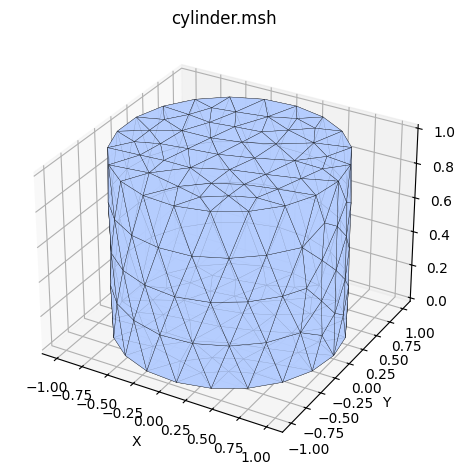

In [971]:
from pathlib import Path
from benchmarks._plot_mesh import show_mesh

mesh = Path(getattr(bench, "msh_path", "coarse_hyperboloid.msh")).resolve()
print("Plotting mesh:", mesh)
show_mesh(mesh)


### 1.3 Canonicalize & Transform  

In [972]:
# Part-2: transform to canonical space and write <mesh>_COEFFS_Transformed.csv
out_tr_csv = bench.run_transform_stage()  # uses the Part-1 CSV by default
bench.coeffs_tr_df.head(), bench.coeffs_tr_meta


(   triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
 0            0     0   106     2                 1                 1   
 1            1    21   110     0                 1                 1   
 2            2    24   106     0                 1                 1   
 3            3     0   110    24                 1                 1   
 4            4     1   108    22                 1                 1   
 
    scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
 0                 1         1.000000    -2.449294e-16             1.00  ...   
 1                 1         0.955573    -2.947552e-01             1.00  ...   
 2                 1         1.000000    -2.449294e-16             0.75  ...   
 3                 1         1.000000    -2.449294e-16             1.00  ...   
 4                 1         1.000000    -2.449294e-16             0.00  ...   
 
    ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
 0    

### 1.4 Curved Volume Estimation, Vertex-Wise Allocation, Aggregation and Error Analysis

In [973]:


import numpy as np, pandas as pd
# Stage 3 (works regardless of CWD if you applied the _find_script fix)
bench.run_volume_stage(tr_csv=bench.coeffs_tr_meta["out_csv"])

vol_csv = bench.vol_meta["vol_csv"]
vdf = bench.vol_df if (getattr(bench, "vol_df", None) is not None and "Vcorrection" in bench.vol_df) \
     else pd.read_csv(vol_csv)
V_sum = float(np.nansum(vdf.get("Vcorrection", 0)))

rel = (3.10799717 + V_sum - 3.14159265) / 3.14159265 * 100
print("**************************************************")
print(f"Volume CSV: {vol_csv}\nrelative error {rel:.6f}%")
print("**************************************************")


**************************************************
Volume CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/cylinder_COEFFS_Transformed_Volume.csv
relative error 0.000004%
**************************************************


## 2. Hyperboloid
### 2.1 Load Hyperboloid Mesh & Fit Local Quadrics (ABC Coefficients)

In [974]:
from benchmarks._benchmark_cases import QuadricCoeffsFromMsh

bench = QuadricCoeffsFromMsh("coarse_hyperboloid.msh", method={})
bench.run_coeffs_stage(min_pts=10, theta_max_deg=35.0)
bench.coeffs_df.head(3), bench.coeffs_meta



[triangles] explicit surface faces: 238 (from 3 block(s))
[mesh] points=129  surface_triangles=238
[smooth] components: 3 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/coarse_hyperboloid_COEFFS.csv  (rows kept=124, skipped_flat=114, total_tris=238)
[ok] Non-planar ABC rows written.


(   triangle_id  component_id  component_size  A_id        Ax        Ay  \
 0           57             1             124     0  1.414214  0.000000   
 1           58             1             124    18  1.291948 -0.575212   
 2           59             1             124     4  1.131429  0.000000   
 
          Az  B_id        Bx        By  ...       C_A       C_B       C_C  \
 0 -1.000000     5  1.291948  0.575212  ...  1.000051  1.000000 -1.000000   
 1 -1.000000     0  1.414214  0.000000  ...  1.000051  1.000000 -1.000000   
 2  0.529277    19  1.291948  0.575212  ...  0.999972  0.999963 -0.999968   
 
         C_D       C_E       C_F       C_G       C_H       C_I  C_J  
 0 -0.000006  0.000065  0.000000 -0.000055  0.000000 -0.000069 -1.0  
 1 -0.000006  0.000065  0.000000 -0.000055  0.000000 -0.000069 -1.0  
 2  0.000000 -0.000049  0.000011  0.000026 -0.000009  0.000056 -1.0  
 
 [3 rows x 59 columns],
 {'out_csv': '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/coarse_hyp

### 2.2 Display Hyperboloid Mesh

Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/coarse_hyperboloid.msh

[loaded] coarse_hyperboloid.msh
  points: 129
  cells[triangle]: 57
  cells[triangle]: 124
  cells[triangle]: 57
  cells[tetra]: 355
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


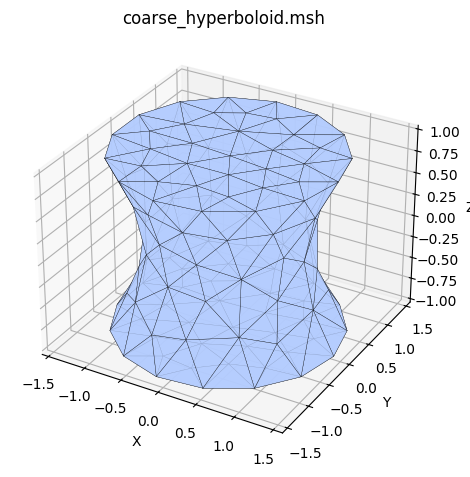

In [975]:
from pathlib import Path
from benchmarks._plot_mesh import show_mesh

mesh = Path(getattr(bench, "msh_path", "coarse_hyperboloid.msh")).resolve()
print("Plotting mesh:", mesh)
show_mesh(mesh)


### 2.3 Canonicalize & Transform

In [976]:
out_tr_csv = bench.run_transform_stage()  # uses the Part-1 CSV by default
bench.coeffs_tr_df.head(), bench.coeffs_tr_meta

(   triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
 0           57     0     5     2          1.000002          1.000011   
 1           58    18     0     2          0.999993          1.000009   
 2           59     4    19     1          1.000002          1.000014   
 3           60    32     4     1          1.000004          1.000016   
 4           61     3    62     2          1.000003          1.000003   
 
    scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
 0          1.000010        -1.414201         0.000000    -1.000005e+00  ...   
 1          1.000008         1.393921        -0.238697    -1.000008e+00  ...   
 2          1.000009         1.123646        -0.132399     5.292882e-01  ...   
 3          1.000010        -1.385557         0.283155     1.000008e+00  ...   
 4          1.000006         0.000000         0.999997     2.682781e-15  ...   
 
    ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
 0    

### 2.4 Curved Volume Estimation, Vertex-Wise Allocation, Aggregation and Error Analysis

In [977]:


import numpy as np, pandas as pd
# Stage 3 (works regardless of CWD if you applied the _find_script fix)
bench.run_volume_stage(tr_csv=bench.coeffs_tr_meta["out_csv"])

vol_csv = bench.vol_meta["vol_csv"]
vdf = bench.vol_df if (getattr(bench, "vol_df", None) is not None and "Vcorrection" in bench.vol_df) \
     else pd.read_csv(vol_csv)
V_sum = float(np.nansum(vdf.get("Vcorrection", 0)))

rel = ( 8.30147792 + V_sum - 8.37758041)/8.37758041*100
print("**************************************************")
print(f"Volume CSV: {vol_csv}\nrelative error {rel:.6f}%")
print("**************************************************")


**************************************************
Volume CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/coarse_hyperboloid_COEFFS_Transformed_Volume.csv
relative error 0.039775%
**************************************************


## 3. Paraboloid
### 3.1 Load Paraboloid Mesh & Fit Local Quadrics (ABC Coefficients)

In [978]:
from benchmarks._benchmark_cases import QuadricCoeffsFromMsh

bench = QuadricCoeffsFromMsh("coarse_paraboloid.msh", method={})
bench.run_coeffs_stage(min_pts=10, theta_max_deg=35.0)
bench.coeffs_df.head(3), bench.coeffs_meta



[triangles] explicit surface faces: 174 (from 2 block(s))
[mesh] points=97  surface_triangles=174
[smooth] components: 2 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/coarse_paraboloid_COEFFS.csv  (rows kept=117, skipped_flat=57, total_tris=174)
[ok] Non-planar ABC rows written.


(   triangle_id  component_id  component_size  A_id        Ax   Ay        Az  \
 0            0             0             117     2  0.455629  0.0  0.207596   
 1            1             0             117     0  0.000000  0.0  0.000000   
 2            2             0             117     0  0.000000  0.0  0.000000   
 
    B_id        Bx        By  ...  C_A  C_B       C_C  C_D       C_E  C_F  C_G  \
 0    51  0.177750 -0.411273  ...  1.0  1.0  0.000007  0.0  0.000006  0.0  0.0   
 1    53  0.180521  0.418341  ...  1.0  1.0  0.000000  0.0  0.000000  0.0  0.0   
 2    52 -0.245238 -0.413616  ...  1.0  1.0  0.000010  0.0  0.000009  0.0  0.0   
 
    C_H       C_I           C_J  
 0  0.0 -1.000005  1.770423e-07  
 1  0.0 -1.000000 -3.994063e-07  
 2  0.0 -1.000005  1.669441e-07  
 
 [3 rows x 59 columns],
 {'out_csv': '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/coarse_paraboloid_COEFFS.csv',
  'total_tris': 174,
  'skipped_flat': 57})

### 3.2 Paraboloid Mesh Display

Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/coarse_paraboloid.msh

[loaded] coarse_paraboloid.msh
  points: 97
  cells[triangle]: 117
  cells[triangle]: 57
  cells[tetra]: 264
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


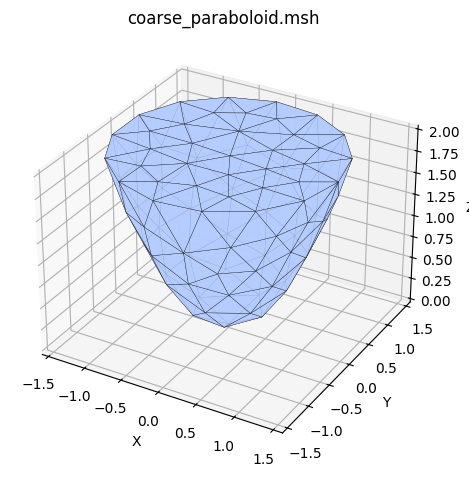

In [979]:
from pathlib import Path
from benchmarks._plot_mesh import show_mesh

mesh = Path(getattr(bench, "msh_path", "coarse_hyperboloid.msh")).resolve()
print("Plotting mesh:", mesh)
show_mesh(mesh)


### 3.3 Canonicalize & Transform

In [980]:
out_tr_csv = bench.run_transform_stage()  # uses the Part-1 CSV by default
bench.coeffs_tr_df.head(), bench.coeffs_tr_meta

(   triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
 0            0     2    51     0                 1                 1   
 1            1     0    53     2                 1                 1   
 2            2     0    52    20                 1                 1   
 3            3    20    53     0                 1                 1   
 4            4    51    52     0                 1                 1   
 
    scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
 0                 1         0.455629         0.000000         0.207596  ...   
 1                 1         0.000000         0.000000         0.000000  ...   
 2                 1         0.000000         0.000000         0.000000  ...   
 3                 1        -0.427680         0.048233         0.185238  ...   
 4                 1         0.177750        -0.411273         0.200740  ...   
 
    ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
 0    

### 3.4 Curved Volume Estimation, Vertex-Wise Allocation, Aggregation and Error Analysis

In [981]:
import numpy as np, pandas as pd
# Stage 3 (works regardless of CWD if you applied the _find_script fix)
bench.run_volume_stage(tr_csv=bench.coeffs_tr_meta["out_csv"])

vol_csv = bench.vol_meta["vol_csv"]
vdf = bench.vol_df if (getattr(bench, "vol_df", None) is not None and "Vcorrection" in bench.vol_df) \
     else pd.read_csv(vol_csv)
V_sum = float(np.nansum(vdf.get("Vcorrection", 0)))

rel = (6.00336629 + V_sum - 6.28318531) / 6.28318531 * 100
print("**************************************************")
print(f"Volume CSV: {vol_csv}\nrelative error {rel:.6f}%")
print("**************************************************")


**************************************************
Volume CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/coarse_paraboloid_COEFFS_Transformed_Volume.csv
relative error 0.028750%
**************************************************


## 4. Parabolic Cylinder
### 4.1 Load Parabolic Cylinder Mesh & Fit Local Quadrics (ABC Coefficients)

In [982]:
from benchmarks._benchmark_cases import QuadricCoeffsFromMsh

bench = QuadricCoeffsFromMsh("parabolic_cylinder_y_eq_x2_y1slice.msh", method={})
bench.run_coeffs_stage(min_pts=10, theta_max_deg=35.0)
bench.coeffs_df.head(3), bench.coeffs_meta


[triangles] explicit surface faces: 266 (from 9 block(s))
[mesh] points=135  surface_triangles=266
[smooth] components: 5 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/parabolic_cylinder_y_eq_x2_y1slice_COEFFS.csv  (rows kept=104, skipped_flat=162, total_tris=266)
[ok] Non-planar ABC rows written.


(   triangle_id  component_id  component_size  A_id        Ax        Ay   Az  \
 0           52             1             104     0 -1.414214  2.000000 -1.0   
 1           53             1             104    22 -1.222177  1.493717 -1.0   
 2           54             1             104    10 -1.414214  2.000000  0.5   
 
    B_id        Bx        By  ...       C_A       C_B  C_C       C_D  C_E  C_F  \
 0    70 -1.292450  1.670427  ... -1.004583 -0.000468  0.0 -0.002393  0.0  0.0   
 1    70 -1.292450  1.670427  ... -0.999991  0.000000  0.0  0.000000  0.0  0.0   
 2    66 -1.288155  1.659344  ... -1.000009  0.000000  0.0 -0.000007  0.0  0.0   
 
         C_G  C_H  C_I           C_J  
 0 -0.003896  1.0  0.0 -1.240352e-03  
 1  0.000008  1.0  0.0  2.655846e-06  
 2  0.000000  1.0  0.0 -7.262105e-07  
 
 [3 rows x 59 columns],
 {'out_csv': '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/parabolic_cylinder_y_eq_x2_y1slice_COEFFS.csv',
  'total_tris': 266,
  'skipped_flat': 162})

### 4.2 Parabolic Cylinder Mesh Display

Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/parabolic_cylinder_y_eq_x2_y1slice.msh

[loaded] parabolic_cylinder_y_eq_x2_y1slice.msh
  points: 135
  cells[triangle]: 52
  cells[triangle]: 26
  cells[triangle]: 26
  cells[triangle]: 21
  cells[triangle]: 21
  cells[triangle]: 42
  cells[triangle]: 52
  cells[triangle]: 13
  cells[triangle]: 13
  cells[tetra]: 271
  cells[tetra]: 149
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


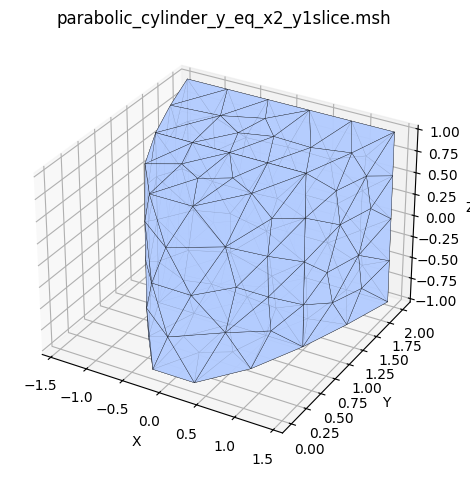

In [983]:
from pathlib import Path
from benchmarks._plot_mesh import show_mesh

mesh = Path(getattr(bench, "msh_path", "coarse_hyperboloid.msh")).resolve()
print("Plotting mesh:", mesh)
show_mesh(mesh)


### 4.3 Canonicalize & Transform


In [984]:
out_tr_csv = bench.run_transform_stage()  # uses the Part-1 CSV by default
bench.coeffs_tr_df.head(), bench.coeffs_tr_meta

(   triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
 0           52     0    70     8          1.000005                 1   
 1           53    22    70     0          1.000005                 1   
 2           54    10    66     1          0.999995                 1   
 3           55     1    66    23          0.999995                 1   
 4           56     4    67    22          0.999999                 1   
 
    scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
 0                 1        -1.414207         2.000000             -1.0  ...   
 1                 1        -1.222172         1.493717             -1.0  ...   
 2                 1        -1.414220         2.000000              0.5  ...   
 3                 1        -1.414220         2.000000              1.0  ...   
 4                 1        -1.000001         1.000000             -1.0  ...   
 
    ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
 0    

### 4.4 Curved Volume Estimation, Vertex-Wise Allocation, Aggregation and Error Analysis

In [985]:

import numpy as np, pandas as pd
# Stage 3 (works regardless of CWD if you applied the _find_script fix)
bench.run_volume_stage(tr_csv=bench.coeffs_tr_meta["out_csv"])

vol_csv = bench.vol_meta["vol_csv"]
vdf = bench.vol_df if (getattr(bench, "vol_df", None) is not None and "Vcorrection" in bench.vol_df) \
     else pd.read_csv(vol_csv)
V_sum = float(np.nansum(vdf.get("Vcorrection", 0)))

rel = ( 7.44963674  + V_sum - 7.54247233 )/7.54247233*100
print("**************************************************")
print(f"Volume CSV: {vol_csv}\nrelative error {rel:.6f}%")
print("**************************************************")


**************************************************
Volume CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/parabolic_cylinder_y_eq_x2_y1slice_COEFFS_Transformed_Volume.csv
relative error -0.000110%
**************************************************


## 5. Hyperbolic Cylinder
### 5.1 Load Hyperbolic Cylinder Mesh & Fit Local Quadrics (ABC Coefficients)

In [986]:
from benchmarks._benchmark_cases import QuadricCoeffsFromMsh

bench = QuadricCoeffsFromMsh("hyperbola_cylinder_x2_minus_y2_z1slice.msh", method={})
bench.run_coeffs_stage(min_pts=10, theta_max_deg=35.0)
bench.coeffs_df.head(3), bench.coeffs_meta



[triangles] explicit surface faces: 349 (from 11 block(s))
[mesh] points=176  surface_triangles=349
[smooth] components: 7 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS.csv  (rows kept=72, skipped_flat=277, total_tris=349)
[ok] Non-planar ABC rows written.


(   triangle_id  component_id  component_size  A_id        Ax        Ay   Az  \
 0          154             4              72     0  2.236068  2.000000  0.0   
 1          155             4              72    29  1.843168  1.548311  0.0   
 2          156             4              72    15  2.236068  2.000000  0.5   
 
    B_id        Bx        By  ...       C_A       C_B  C_C       C_D  C_E  C_F  \
 0   120  1.940029  1.662442  ...  0.999879 -1.000026  0.0  0.000143  0.0  0.0   
 1   120  1.940029  1.662442  ...  1.000023 -0.999997  0.0 -0.000025  0.0  0.0   
 2   120  1.940029  1.662442  ...  1.000144 -0.999950  0.0 -0.000192  0.0  0.0   
 
         C_G       C_H  C_I  C_J  
 0  0.000107 -0.000086  0.0 -1.0  
 1 -0.000021  0.000017  0.0 -1.0  
 2 -0.000119  0.000102  0.0 -1.0  
 
 [3 rows x 59 columns],
 {'out_csv': '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS.csv',
  'total_tris': 349,
  'skipped_flat': 277})

### 5.2 Display Hyperbolic Cylinder Mesh

Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/hyperbola_cylinder_x2_minus_y2_z1slice.msh

[loaded] hyperbola_cylinder_x2_minus_y2_z1slice.msh
  points: 176
  cells[triangle]: 12
  cells[triangle]: 55
  cells[triangle]: 32
  cells[triangle]: 55
  cells[triangle]: 36
  cells[triangle]: 12
  cells[triangle]: 12
  cells[triangle]: 32
  cells[triangle]: 55
  cells[triangle]: 36
  cells[triangle]: 12
  cells[tetra]: 268
  cells[tetra]: 268
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


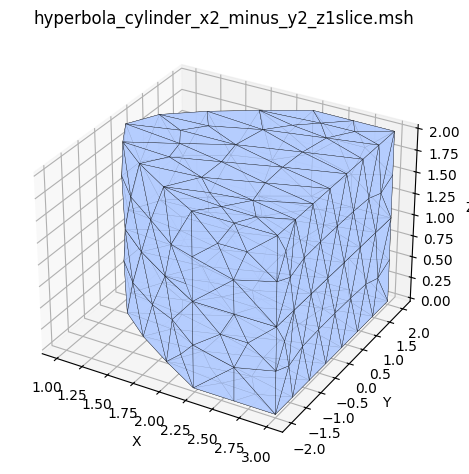

In [987]:
from pathlib import Path
from benchmarks._plot_mesh import show_mesh

mesh = Path(getattr(bench, "msh_path", "coarse_hyperboloid.msh")).resolve()
print("Plotting mesh:", mesh)
show_mesh(mesh)


### 5.3 Canonicalize & Transform 


In [988]:
out_tr_csv = bench.run_transform_stage()  # uses the Part-1 CSV by default
bench.coeffs_tr_df.head(), bench.coeffs_tr_meta

(   triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
 0          154     0   120    15          0.999992          1.000001   
 1          155    29   120     0          0.999989          1.000001   
 2          156    15   120     3          1.000060          0.999987   
 3          157     3   120    38          1.000000          1.000000   
 4          158     5   122    23          0.999990          1.000001   
 
    scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
 0                 1         2.236086         1.999998              0.0  ...   
 1                 1         1.843189         1.548309              0.0  ...   
 2                 1         2.235933         2.000026              0.5  ...   
 3                 1         2.236068         2.000000              1.0  ...   
 4                 1         2.236091        -1.999997              0.0  ...   
 
    ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
 0    

### 5.4 Curved Volume Estimation, Vertex-Wise Allocation, Aggregation and Error Analysis

In [989]:


import numpy as np, pandas as pd
# Stage 3 (works regardless of CWD if you applied the _find_script fix)
bench.run_volume_stage(tr_csv=bench.coeffs_tr_meta["out_csv"])

vol_csv = bench.vol_meta["vol_csv"]
vdf = bench.vol_df if (getattr(bench, "vol_df", None) is not None and "Vcorrection" in bench.vol_df) \
     else pd.read_csv(vol_csv)
V_sum = float(np.nansum(vdf.get("Vcorrection", 0)))

rel = (  12.10482688  + V_sum -  12.16845714 )/ 12.16845714*100
print("**************************************************")
print(f"Volume CSV: {vol_csv}\nrelative error {rel:.6f}%")
print("**************************************************")


**************************************************
Volume CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/hyperbola_cylinder_x2_minus_y2_z1slice_COEFFS_Transformed_Volume.csv
relative error -0.000275%
**************************************************


## 6. Ellipsoid
### 6.1 Load Ellipsoid Mesh & Fit Local Quadrics (ABC Coefficients)

In [990]:
from benchmarks._benchmark_cases import QuadricCoeffsFromMsh

bench = QuadricCoeffsFromMsh("Ellip_0_sub0_full.msh", method={})
bench.run_coeffs_stage(min_pts=10, theta_max_deg=35.0)
bench.coeffs_df.head(3), bench.coeffs_meta



[triangles] explicit surface faces: 20 (from 1 block(s))
[mesh] points=12  surface_triangles=20
[smooth] components: 10 (theta_max=35.0°)
[write] CSV -> /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/Ellip_0_sub0_full_COEFFS.csv  (rows kept=20, skipped_flat=0, total_tris=20)
[ok] Non-planar ABC rows written.


(   triangle_id  component_id  component_size  A_id        Ax        Ay  \
 0            0             0               2     4  0.000000  0.525731   
 1            1             1               3     9  0.000000 -0.525731   
 2            2             2               3     1 -1.275976  0.000000   
 
          Az  B_id        Bx        By  ...       C_A  C_B     C_C  C_D  C_E  \
 0 -0.680521     9  0.000000 -0.525731  ...  0.444444  1.0  1.5625  0.0  0.0   
 1 -0.680521    10  1.275976  0.000000  ...  0.444444  1.0  1.5625  0.0  0.0   
 2  0.420585     7  0.000000 -0.525731  ...  0.444444  1.0  1.5625  0.0  0.0   
 
    C_F  C_G  C_H  C_I  C_J  
 0  0.0  0.0  0.0  0.0 -1.0  
 1  0.0  0.0  0.0  0.0 -1.0  
 2  0.0  0.0  0.0  0.0 -1.0  
 
 [3 rows x 59 columns],
 {'out_csv': '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/Ellip_0_sub0_full_COEFFS.csv',
  'total_tris': 20,
  'skipped_flat': 0})

### 6.2 Ellipsoid Mesh Display

Plotting mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/Ellip_0_sub0_full.msh

[loaded] Ellip_0_sub0_full.msh
  points: 12
  cells[tetra]: 18
  cells[triangle]: 20
[info] PyVista unavailable or failed (No module named 'pyvista'). Using Matplotlib fallback.


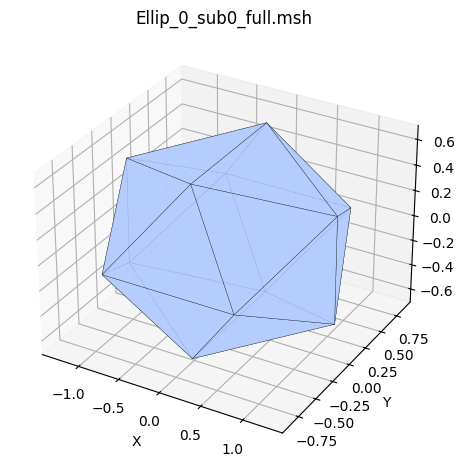

In [991]:
from pathlib import Path
from benchmarks._plot_mesh import show_mesh

mesh = Path(getattr(bench, "msh_path", "coarse_hyperboloid.msh")).resolve()
print("Plotting mesh:", mesh)
show_mesh(mesh)


### 6.3 Canonicalize & Transform

In [992]:
out_tr_csv = bench.run_transform_stage()  # uses the Part-1 CSV by default
bench.coeffs_tr_df.head(), bench.coeffs_tr_meta

(   triangle_id  A_id  B_id  C_id  scale_factors1_x  scale_factors1_y  \
 0            0     4     9    10               0.8               1.0   
 1            1     9    10    11               0.8               1.0   
 2            2     1     7     8               0.8               1.0   
 3            3     1     2     7               0.8               1.0   
 4            4     2     6     7               0.8               1.0   
 
    scale_factors1_z  A_transformed_x  A_transformed_y  A_transformed_z  ...  \
 0               1.5        -0.850651         0.525731         0.000000  ...   
 1               1.5        -0.850651        -0.525731         0.000000  ...   
 2               1.5         0.525731         0.000000         0.850651  ...   
 3               1.5         0.525731         0.000000         0.850651  ...   
 4               1.5         0.850651         0.525731         0.000000  ...   
 
    ABC_new_A  ABC_new_B  ABC_new_C  ABC_new_D  ABC_new_E  ABC_new_F  \
 0    

### 6.4 Curved Volume Estimation, Vertex-Wise Allocation, Aggregation and Error Analysis

In [993]:


import numpy as np, pandas as pd
# Stage 3 (works regardless of CWD if you applied the _find_script fix)
bench.run_volume_stage(tr_csv=bench.coeffs_tr_meta["out_csv"])

vol_csv = bench.vol_meta["vol_csv"]
vdf = bench.vol_df if (getattr(bench, "vol_df", None) is not None and "Vcorrection" in bench.vol_df) \
     else pd.read_csv(vol_csv)
V_sum = float(np.nansum(vdf.get("Vcorrection", 0)))

rel = (5.02654825 - 3.04338074 - V_sum)/5.02654825*100
print("**************************************************")
print(f"Volume CSV: {vol_csv}\nrelative error {rel:.6f}%")
print("**************************************************")


**************************************************
Volume CSV: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib-master/Ellip_0_sub0_full_COEFFS_Transformed_Volume.csv
relative error 0.000004%
**************************************************
